In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/qwen-3/transformers/0.6b-base/1/config.json
/kaggle/input/qwen-3/transformers/0.6b-base/1/merges.txt
/kaggle/input/qwen-3/transformers/0.6b-base/1/README.md
/kaggle/input/qwen-3/transformers/0.6b-base/1/tokenizer.json
/kaggle/input/qwen-3/transformers/0.6b-base/1/vocab.json
/kaggle/input/qwen-3/transformers/0.6b-base/1/tokenizer_config.json
/kaggle/input/qwen-3/transformers/0.6b-base/1/model.safetensors
/kaggle/input/qwen-3/transformers/0.6b-base/1/generation_config.json
/kaggle/input/anime-recommendations-database/rating.csv
/kaggle/input/anime-recommendations-database/anime.csv


***Anime Adventure Blog: How We Built a Smart Recommendation Bot*** 

Qwen3 is a large language model (LLM) developed by Alibaba Cloud, part of the Qwen series — one of the most powerful open-source LLMs available today. It's trained on massive amounts of text data from the web, books, code, and more.

The notebook you're building leverages Qwen3’s capabilities in combination with a real anime recommendation dataset, allowing users to:

1. Understand Anime Trends
2. Generate Personalized Anime Recommendations
3. Combine Data Filtering with AI Creativity
4. Anime Recommendation depends on out mood using Qwen Thinking mode.

In [11]:
import pandas as pd
import matplotlib.pyplot as plot
import seaborn as sns
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM


Load Qwen3 model and tokenizer

In [13]:
model_path="/kaggle/input/qwen-3/transformers/0.6b-base/1"
tokenizer=AutoTokenizer.from_pretrained(model_path)

tokenizer = AutoTokenizer.from_pretrained(model_path, local_files_only=True)
model = AutoModelForCausalLM.from_pretrained(
    model_path, local_files_only=True
).to("cuda" if torch.cuda.is_available() else "cpu")


df=pd.read_csv("/kaggle/input/anime-recommendations-database/anime.csv")
print(df.head(5))


   anime_id                              name  \
0     32281                    Kimi no Na wa.   
1      5114  Fullmetal Alchemist: Brotherhood   
2     28977                          Gintama°   
3      9253                       Steins;Gate   
4      9969                     Gintama&#039;   

                                               genre   type episodes  rating  \
0               Drama, Romance, School, Supernatural  Movie        1    9.37   
1  Action, Adventure, Drama, Fantasy, Magic, Mili...     TV       64    9.26   
2  Action, Comedy, Historical, Parody, Samurai, S...     TV       51    9.25   
3                                   Sci-Fi, Thriller     TV       24    9.17   
4  Action, Comedy, Historical, Parody, Samurai, S...     TV       51    9.16   

   members  
0   200630  
1   793665  
2   114262  
3   673572  
4   151266  


Exploring the amine dataset

In [48]:
# Shape of the dataset
print(df.shape)

(11954, 7)


In [49]:
#Column names of the dataset
print(df.columns)

Index(['anime_id', 'name', 'genre', 'type', 'episodes', 'rating', 'members'], dtype='object')


In [50]:
# Summary of data types and null values
print(df.info())

# Summary statistics for numeric columns
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 11954 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  11954 non-null  int64  
 1   name      11954 non-null  object 
 2   genre     11903 non-null  object 
 3   type      11954 non-null  object 
 4   episodes  11954 non-null  float64
 5   rating    11876 non-null  float64
 6   members   11954 non-null  int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 747.1+ KB
None
           anime_id      episodes        rating       members
count  11954.000000  11954.000000  11876.000000  1.195400e+04
mean   13589.705120     12.382550      6.480333  1.836856e+04
std    11209.052798     46.865352      1.021995  5.511078e+04
min        1.000000      1.000000      1.670000  5.000000e+00
25%     3380.250000      1.000000      5.890000  2.290000e+02
50%     9934.500000      2.000000      6.570000  1.579500e+03
75%    23644.500000     12.000000      7.18

In [20]:
#Filter and visualize the dataset
print("The top 5 highest-rated-amine")
display(df.sort_values("rating", ascending=False).head()[["name", "genre", "type", "rating"]])

The top 5 highest-rated-amine


,name,genre,type,rating
10464,Taka no Tsume 8: Yoshida-kun no X-Files,"Comedy, Parody",Movie,10.00
10400,Spoon-hime no Swing Kitchen,"Adventure, Kids",TV,9.60
9595,Mogura no Motoro,Slice of Life,Movie,9.50
0,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,9.37
9078,Kahei no Umi,Historical,Movie,9.33


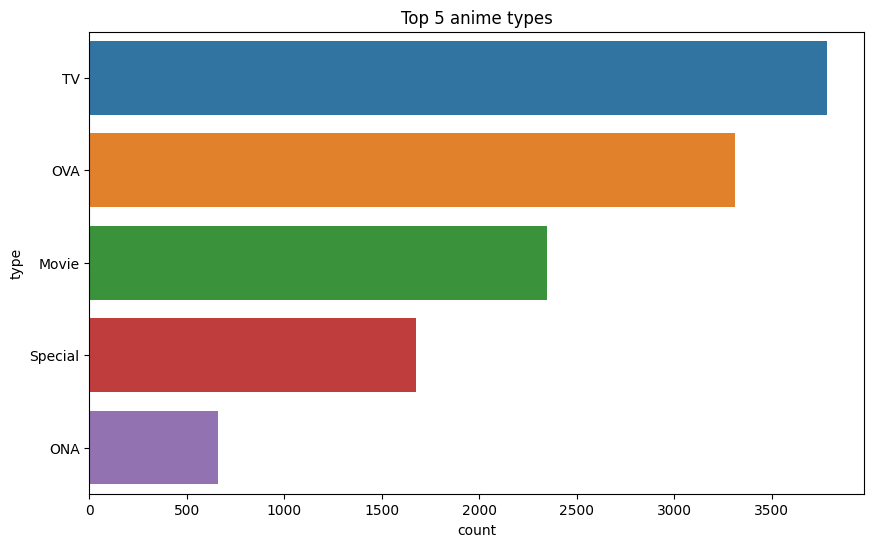

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


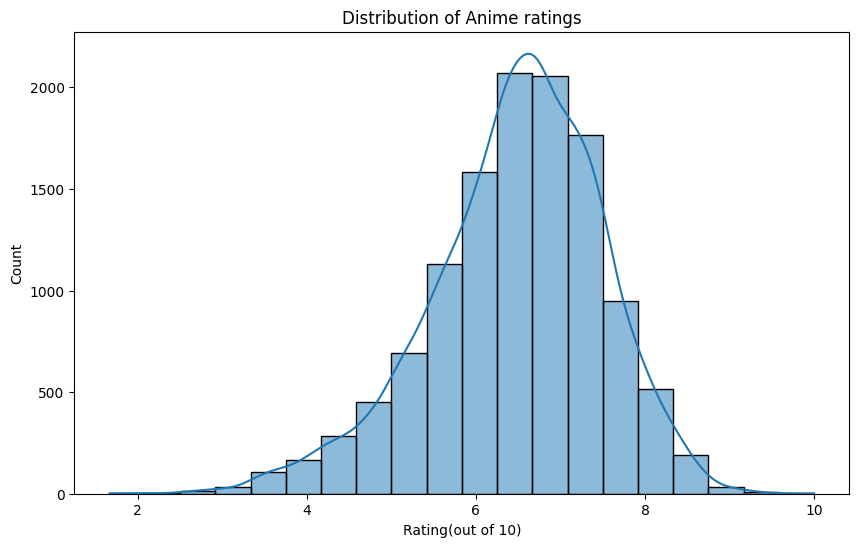

In [26]:
plot.figure(figsize=(10,6))
sns.countplot(y="type",data=df,order=df["type"].value_counts().index[:5])
plot.title("Top 5 anime types")
plot.show()


plot.figure(figsize=(10,6))
sns.histplot(df["rating"],bins=20, kde=True)
plot.title("Distribution of Anime ratings")
plot.xlabel("Rating(out of 10)")
plot.ylabel("Count")
plot.show()

Anime Recommendation Bot

Helper function for model inference
Using Qwen 0.6B to generate personalized anime suggestions

In [39]:
def qwen_generate(prompt):
    inputs=tokenizer(prompt, return_tensors="pt").to(model.device)
    outputs=model.generate(
        **inputs,
        max_new_tokens=250,
        num_return_sequences=1,
        pad_token_id=tokenizer.eos_token_id , 
        temperature=0.7,
        do_sample=True
    )
    # Slice off the prompt tokens, keep only generated part because if we dont slice off, the question seems to come as the answer instead of the output
    generated_tokens = outputs[0][inputs["input_ids"].shape[1]:]
    return tokenizer.decode(generated_tokens, skip_special_tokens=True)

Use Qwen 0.6B to generate personalized anime suggestions¶


1: Genre-Based Recommendations

In [31]:
prompt = """Suggest 3 action anime for someone who loves complex villains.  
Explain why each matches the request. Use emojis."""
response = qwen_generate(prompt)
print(response)

Suggest 3 action anime for someone who loves complex villains.  
Explain why each matches the request. Use emojis. 1. *The Walking Dead* - The complex and morally ambiguous nature of the characters is a perfect fit for someone who enjoys reading about the struggles of a community in a post-apocalyptic world. The character of Sam Wilson is a prime example, as he is a former soldier who becomes a vigilante after the town of Blackpool is wiped out. His complex past and struggle for survival make him a compelling villain.  
2. *Naruto* - The intricate and often unpredictable nature of the Naruto universe is perfect for someone who loves complex characters. The character of Sasuke Uchiha is a prime example, as he is a powerful ninja who is a complex individual with a troubled past. His relationships with his friends and his interactions with the world around him make him a fascinating villain.  
3. *My Hero Academia* - The complex and morally ambiguous nature of the characters in My Hero Ac

2. Underrated Gems


In [32]:
prompt = "List 3 underrated anime with unique art styles. Include genres and summaries."
print(qwen_generate(prompt))

List 3 underrated anime with unique art styles. Include genres and summaries. Sure, here are three underrated anime with unique art styles:

1. **"Gurren Lagann" (2002)**  
   - **Genre**: Action, Adventure, Drama  
   - **Summary**: Adapted from a popular manga by Takashi Miike, Gurren Lagann is a manga series that blends action, emotional drama, and science fiction. The anime adaptation, directed by Eiji Yoshikawa, features a sleek, stylized animation that brings the manga's intense and often dark world to life. The art style is highly detailed and attention to detail, creating a visually stunning and immersive experience.

2. **"Kamen Rider W" (2011)**  
   - **Genre**: Action, Anime Drama, Comic  
   - **Summary**: This anime follows the adventures of Kamen Rider W, a powerful warrior who battles crime and destruction with his allies. The art style is bold and vibrant, with a focus on dynamic compositions and expressive


3. Analyze Trends with Qwen

In [40]:
prompt = """The dataset shows 40% of top-rated animes are action-themed.  
Explain why action anime dominates global popularity. List 3 cultural/historical reasons."""
analysis = qwen_generate(prompt)
print(analysis)

 Also, list 2 technological reasons leading to the dominance of action anime. Finally, what would happen to the popularity of other genres if action anime were banned in some countries?

Action anime dominates global popularity due to several cultural and technological factors. First, the promotion of action anime is deeply rooted in Japanese culture, which has a rich tradition of martial arts and combat sports. This cultural emphasis has created a strong market for action anime, attracting audiences who appreciate realistic and intense storytelling. Second, the media landscape in Japan has been shaped by the popularity of action-oriented content, leading to the development of the "action subculture" within anime fandom. Fans often engage in discussions and share content related to action scenes, further solidifying their place within the action anime community. Third, the global dominance of the Internet has played a significant role. Online platforms have provided a platform for the 

LLM + Dataset Interaction

1. Filter Recommendations Using Data - Combine dataset filters with AI creativity!

In [43]:
# convert the episodes column to numeric if not changed
if df['episodes'].dtype=='object':
    df['episodes']=pd.to_numeric(df['episodes'],errors='coerce')
    #Remove the rows when had failed in conversion
    df.dropna(subset=['episodes'],inplace=True)

# Filter dataset for short series (<=12 episodes)
short_series = df[(df["episodes"] <= 12) & (df["episodes"] > 1)].sort_values("rating", ascending=False)

#Prompting with dataset results
prompt = f"""Based on this list of short anime:\n{short_series.head(5)[['name', 'genre', 'rating']]}\n\n
Suggest 2 binge-worthy short series and explain why they're worth watching."""
print(qwen_generate(prompt))

 Based on the provided list of short anime, here are two binge-worthy series that, according to the given data, would likely appeal to a broad audience:

1. **Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga**  
   - **Why**: This series combines elements of anime classics with modern twists, making it both nostalgic and fresh. The crossover between Haikyuu and Shiratorizawa Ga is particularly intriguing, offering a unique perspective on their worlds. The drama and comedy elements combined make it a fantastic blend for binge-watching.

2. **One Punch Man**  
   - **Why**: One Punch Man is a massive hit, known for its fast-paced action, humor, and heartwarming moments. The series’ emphasis on camaraderie and personal growth, combined with its iconic tagline, makes it a must-watch for fans of action and comedy. It’s also worth noting its strong crossover with *Rurouni Kenshin*, which adds to its appeal.

Both of these series are diverse and cater to different tastes, making them great for 

2. Recommend Based on Mood + Dataset

In [46]:
def recommend_anime_with_context_direct(mood, top_k=5):
    # Build prompt context from dataset
    context = "\n".join([
        f"{row['name']} ({row['genre']}): Rating {row['rating']}"
        for _, row in df.sort_values('rating', ascending=False).head(20).iterrows()
    ])

    prompt = f"""
The user is feeling "{mood}". Recommend up to {top_k} unique anime from the list below that best fit this mood.
Provide a short explanation for each recommendation and only include titles from the list.

Anime List:
{context}

Recommendations:
"""
    result = qwen_generate(prompt)

    # Post-process: keep only numbered lines to remove extra text
    recommendations = []
    for line in result.split("\n"):
        line = line.strip()
        if line and (line[0].isdigit() and '.' in line):
            recommendations.append(line)

    print("Recommendations:")
    for rec in recommendations:
        print("  " + rec)

    return recommendations

# Call interactively
user_mood = input("Please enter your mood, I will recommend top anime for you: ")
recommend_anime_with_context_direct(user_mood)

Please enter your mood, I will recommend top anime for you:  action


Recommendations:
  1. **Taka no Tsume 8: Yoshida-kun no X-Files** - This anime combines comedy with a quirky and original spin on the X-Files franchise, making it a great choice for someone looking for a humorous and lighthearted experience.
  2. **Gintama Movie: Kanketsu-hen** - A series that seamlessly blends action, comedy, and historical elements, it’s a must-watch for fans of both genres.
  3. **Clannad: After Story** - A heartwarming drama that explores themes of forgiveness and redemption, it’s a perfect choice for someone seeking a touching and heartfelt story.
  4. **Gintama Movie: Kanketsu-hen** - Another fantastic series that seamlessly blends action, comedy, and historical elements, offering an entertaining and engaging experience.
  5. **Gintama Movie: Kanketsu-hen** - A series that seamlessly blends action, comedy, and historical elements, making it a great choice for fans of the series.


['1. **Taka no Tsume 8: Yoshida-kun no X-Files** - This anime combines comedy with a quirky and original spin on the X-Files franchise, making it a great choice for someone looking for a humorous and lighthearted experience.',
 '2. **Gintama Movie: Kanketsu-hen** - A series that seamlessly blends action, comedy, and historical elements, it’s a must-watch for fans of both genres.',
 '3. **Clannad: After Story** - A heartwarming drama that explores themes of forgiveness and redemption, it’s a perfect choice for someone seeking a touching and heartfelt story.',
 '4. **Gintama Movie: Kanketsu-hen** - Another fantastic series that seamlessly blends action, comedy, and historical elements, offering an entertaining and engaging experience.',
 '5. **Gintama Movie: Kanketsu-hen** - A series that seamlessly blends action, comedy, and historical elements, making it a great choice for fans of the series.']